In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")



In [4]:
df = pd.read_csv(r"/Users/jeffrinjwebster/Desktop/netflix_titles.csv")

In [6]:
print(df.head())

  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021        

In [ ]:
# Understand the Dataset Structure

In [8]:
print("Shape:", df.shape)

Shape: (8807, 12)


In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
None


In [12]:
print(df.isnull().sum())

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


In [ ]:
# Check for duplicates

In [14]:
print("Duplicates:", df.duplicated().sum())

Duplicates: 0


In [ ]:
# Drop duplicates

In [16]:
df = df.drop_duplicates()

In [ ]:
#Data cleaning

In [20]:
# Fill missing categorical columns with 'Unknown'
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')



In [22]:
# Fill date with earliest known
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['date_added'] = df['date_added'].fillna(method='ffill')

In [ ]:
#Convert Columns

In [24]:
# Convert 'date_added' to datetime and extract year/month
df['date_added'] = pd.to_datetime(df['date_added'])
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

In [26]:
# Extract numeric duration for movies
df['duration_num'] = df['duration'].str.extract('(\d+)').astype(float)

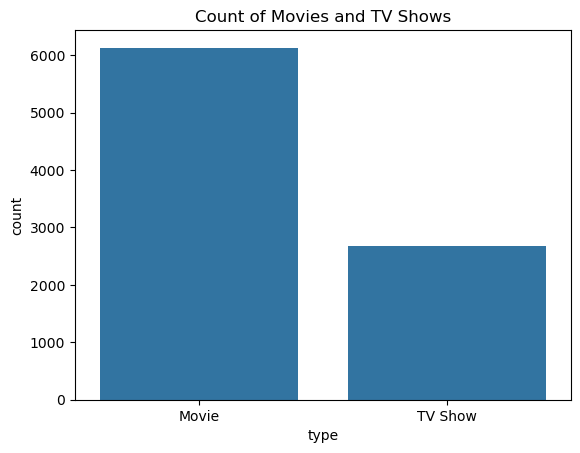

In [28]:
#EDA & Visualizations #Count of Movies vs TV Shows
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='type', data=df)
plt.title('Count of Movies and TV Shows')
plt.show()


In [ ]:
#Content Over Years

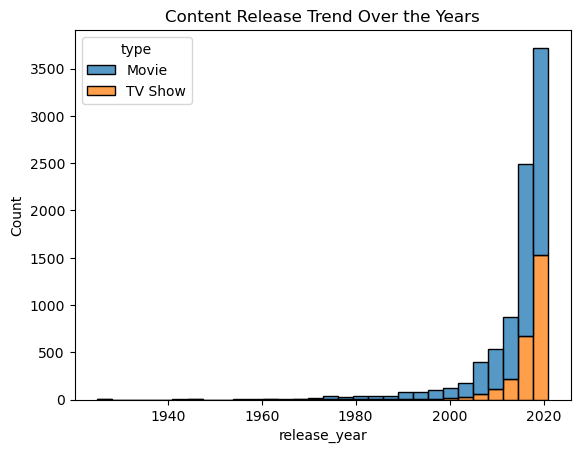

In [30]:
df['release_year'] = df['release_year'].astype(int)

sns.histplot(data=df, x='release_year', hue='type', bins=30, kde=False, multiple='stack')
plt.title('Content Release Trend Over the Years')
plt.show()

In [ ]:
#Top Countries Producing Content

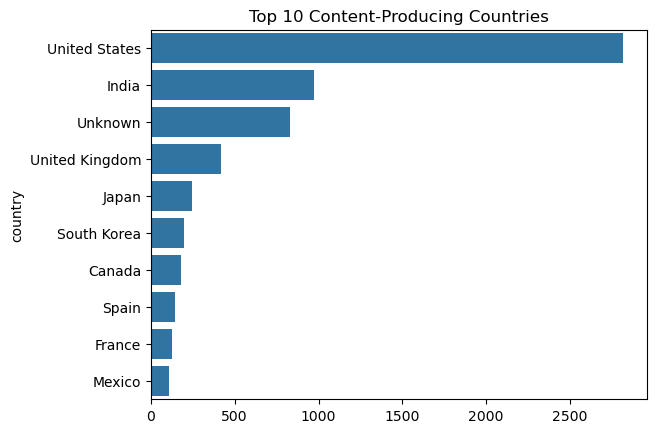

In [32]:
top_countries = df['country'].value_counts().head(10)

sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Content-Producing Countries')
plt.show()

In [ ]:
#Top Genres

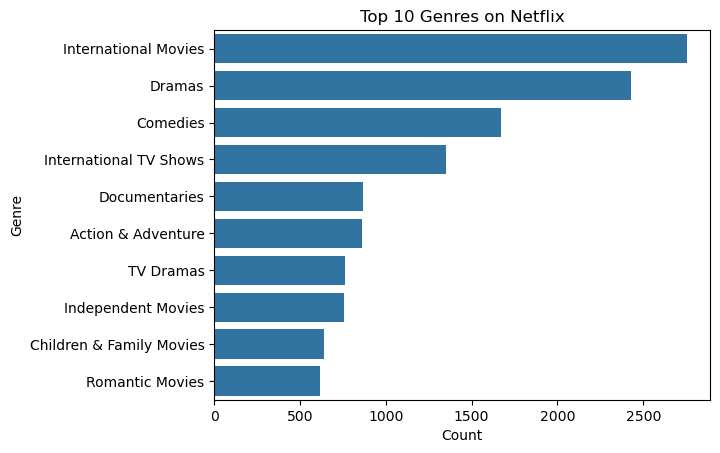

In [34]:
# Genre/Category - explodes 'listed_in' column
from collections import Counter

all_genres = ','.join(df['listed_in']).split(',')
genre_counts = Counter([genre.strip() for genre in all_genres])

top_genres = pd.DataFrame(genre_counts.most_common(10), columns=['Genre', 'Count'])

sns.barplot(data=top_genres, x='Count', y='Genre')
plt.title('Top 10 Genres on Netflix')
plt.show()

In [ ]:
# Prepare Data for Classification Model

In [ ]:
#Select Relevant Features

In [36]:
df_model = df[['type', 'release_year', 'duration_num', 'country', 'year_added']]

In [ ]:
#Encode Target Variable


In [38]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_model['type_encoded'] = le.fit_transform(df_model['type'])

In [ ]:
# Encode Categorical Feature (country)
#We’ll encode country using one-hot encoding.

In [40]:
df_model = pd.get_dummies(df_model, columns=['country'], drop_first=True)

In [ ]:
# Train-Test Split

In [42]:
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=['type', 'type_encoded'])  # features
y = df_model['type_encoded']  # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [46]:
# Check which columns have missing values
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])

duration_num    2
dtype: int64


In [48]:
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]  # make sure target is aligned

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

In [50]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [73]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9988642816581488
[[1212    1]
 [   1  547]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1213
           1       1.00      1.00      1.00       548

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761



In [ ]:
#Visualize Confusion Matrix


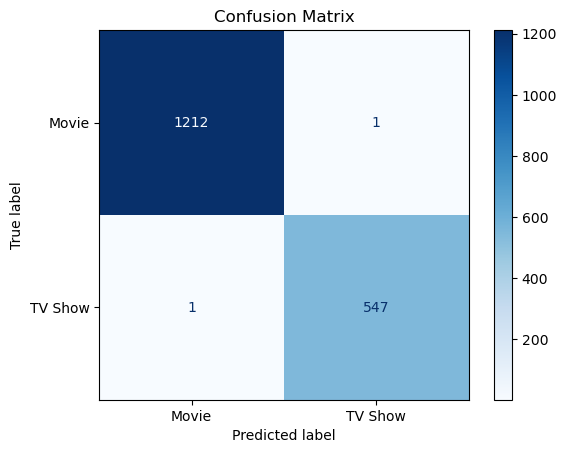

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#Feature Importance (Optional


In [77]:
import numpy as np

In [79]:
# Get feature importance from Logistic Regression
importance = clf.coef_[0]

In [81]:
# Match with feature names
features = X_train.columns
feature_importance = pd.Series(np.abs(importance), index=features).sort_values(ascending=False)

In [83]:
# Plot
import matplotlib.pyplot as plt
import seaborn as sns

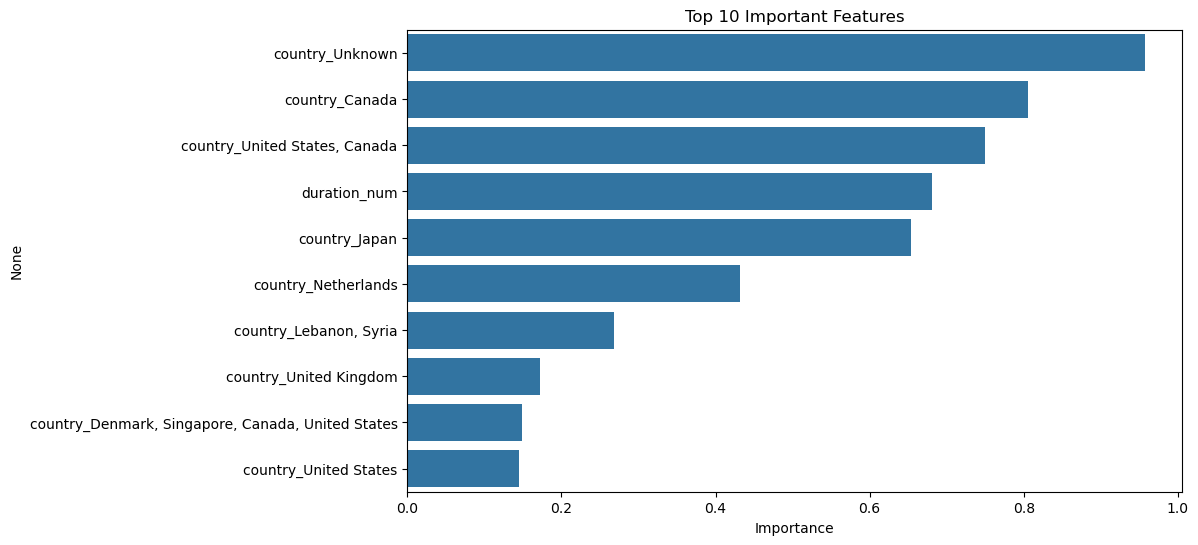

In [85]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[:10], y=feature_importance.index[:10])
plt.title("Top 10 Important Features")
plt.xlabel("Importance")
plt.show()

In [ ]:
#Try Different Models (Bonus – Performance Comparison)

In [87]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("RF Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

RF Accuracy: 0.9994321408290744
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1213
           1       1.00      1.00      1.00       548

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

